# Import

In [99]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, LearningRateScheduler
import keras.backend as K

# Data

In [100]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [101]:
print(f"There are {train_data.shape[0]} passengers with {train_data.shape[1]} features")
print(f"{(train_data['Survived'] == 1).sum()} passengers survived")
print(f"{(train_data['Survived'] == 0).sum()} passengers died")

print(f"Only {(round(train_data['Survived'].mean()*100,1)).sum()}% of passengers survived")

There are 891 passengers with 12 features
342 passengers survived
549 passengers died
Only 38.4% of passengers survived


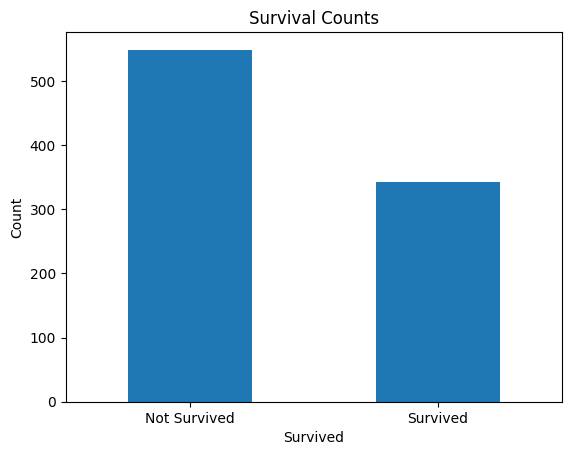

In [102]:
survived_counts = train_data['Survived'].value_counts()
survived_counts.plot(kind='bar')
plt.title('Survival Counts')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Survived', 'Survived'], rotation=0)
plt.show()

In [103]:
# Drop ID, it won't help with predictions
train_data = train_data.drop("PassengerId", axis=1)

In [104]:
# 3 Columns have NaN values, we can impute for Age and Embarked, and just drop the Cabin column
nan_counts = train_data.isna().sum(axis=0)
nan_counts_filtered = nan_counts[nan_counts > 0]
print(nan_counts_filtered)

Age         177
Cabin       687
Embarked      2
dtype: int64


In [105]:
# S is most common by a lot, set the NaN values to S
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [106]:
train_data["Embarked"].fillna("S", inplace=True)

In [107]:
# Replace NaN values in the 'Age' column with the median
median_age = train_data['Age'].median()
train_data['Age'].fillna(median_age, inplace=True)

In [108]:
# Drop columns
train_data = train_data.drop(["Name", "Ticket", "Cabin"], axis=1)

In [109]:
# One hot encode categorical columns
train_data = pd.get_dummies(train_data, columns=['Embarked'], prefix='Embarked')
train_data = pd.get_dummies(train_data, columns=['Sex'])
train_data = train_data.drop("Sex_female", axis=1)
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,3,22.0,1,0,7.2500,0,0,1,1
1,1,1,38.0,1,0,71.2833,1,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1,0
3,1,1,35.0,1,0,53.1000,0,0,1,0
4,0,3,35.0,0,0,8.0500,0,0,1,1


In [110]:
# Normalize the numeric columns
scaler = MinMaxScaler()
cols_to_normalize = ["Age", "Fare"]
train_data[cols_to_normalize] = scaler.fit_transform(train_data[cols_to_normalize])
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,3,0.271174,1,0,0.014151,0,0,1,1
1,1,1,0.472229,1,0,0.139136,1,0,0,0
2,1,3,0.321438,0,0,0.015469,0,0,1,0
3,1,1,0.434531,1,0,0.103644,0,0,1,0
4,0,3,0.434531,0,0,0.015713,0,0,1,1


# Setup Train/Val Data

In [111]:
X = train_data.drop(["Survived"],axis=1)
y = train_data["Survived"]

In [112]:
# There is a data imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [113]:
# Split data into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Models

## Linear Regression

In [114]:
# Set up a Linear Regression model
linReg = LinearRegression()

In [115]:
linReg.fit(X_train, y_train)

LinearRegression()

In [116]:
# Calculate accuracy for training data
train_preds = linReg.predict(X_train)
train_preds = np.round(train_preds).astype(int).flatten()
train_accuracy = accuracy_score(y_train, train_preds)
print("Train accuracy:",round(train_accuracy*100,2),"%")

# Get accuracy for validation data
val_preds = linReg.predict(X_val)
val_preds = np.round(val_preds).astype(int).flatten()
val_accuracy = accuracy_score(y_val, val_preds)
print("Validation accuracy:",round(val_accuracy*100,2),"%")

Train accuracy: 78.98 %
Validation accuracy: 77.82 %


# Neural Network

In [117]:
# Decrease learning rate over time
def schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        return lr * 0.75
    else:
        return lr              
lr_scheduler = LearningRateScheduler(schedule, verbose=1)

In [118]:
# Define the model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [119]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

nn_model.fit(X_train, y_train, epochs=60, batch_size=20, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping,lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/60
42/42 [==============================] - 1s 8ms/step - loss: 0.6778 - accuracy: 0.5589 - val_loss: 0.6373 - val_accuracy: 0.6945 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/60
42/42 [==============================] - 0s 4ms/step - loss: 0.6002 - accuracy: 0.7461 - val_loss: 0.5511 - val_accuracy: 0.7673 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/60
42/42 [==============================] - 0s 3ms/step - loss: 0.5436 - accuracy: 0.7497 - val_loss: 0.5053 - val_accuracy: 0.7927 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/60
42/42 [==============================] - 0s 3ms/step - loss: 0.5039 - accuracy: 0.7679 - val_loss: 0.4691 - val_accuracy: 0.7891 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.000750000

In [120]:
# Calculate accuracy for training data
train_preds = nn_model.predict(X_train)
train_preds = np.round(train_preds).astype(int).flatten()
train_accuracy = accuracy_score(y_train, train_preds)
print("Train accuracy:",round(train_accuracy*100,2),"%")

# Get accuracy for validation data
val_preds = nn_model.predict(X_val)
val_preds = np.round(val_preds).astype(int).flatten()
val_accuracy = accuracy_score(y_val, val_preds)
print("Validation accuracy:",round(val_accuracy*100,2),"%")

26/26 [==============================] - 0s 1ms/step
Train accuracy: 81.41 %
9/9 [==============================] - 0s 2ms/step
Validation accuracy: 81.82 %


## Random Forest

In [121]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameters grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt']
# }

# # Create a Random Forest classifier
# rf_classifier = RandomForestClassifier(random_state=42)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters and the best model
# best_params = grid_search.best_params_
# best_rf_classifier = grid_search.best_estimator_

# # Train the best model on the entire training data
# best_rf_classifier.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = best_rf_classifier.predict(X_test)

# # Evaluate the best model
# print(classification_report(y_test, y_pred))

In [122]:
best_params = {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}

In [123]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(**best_params, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50, random_state=42)

In [124]:
y_pred = rf_classifier.predict(X_train)
print("Train accuracy:",round(accuracy_score(y_train, np.round(y_pred))*100,2),"%")

y_pred = rf_classifier.predict(X_val)
print("Train accuracy:",round(accuracy_score(y_val, np.round(y_pred))*100,2),"%")

Train accuracy: 91.25 %
Train accuracy: 85.45 %


# XGBoost

In [125]:
# Convert data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 3, # Fix overfitting
    'seed': 42
}

# Train the XGBoost model
num_round = 500

evallist = [(dval, 'eval'), (dtrain, 'train')]

# Train the model with early stopping
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=False)

y_pred = bst.predict(dval, ntree_limit=bst.best_ntree_limit)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [126]:
# Calculate accuracy for training data
train_preds = bst.predict(dtrain)
train_preds = np.round(train_preds).astype(int).flatten()
train_accuracy = accuracy_score(y_train, train_preds)
print("Train accuracy:",round(train_accuracy*100,2),"%")

# Get accuracy for validation data
val_preds = bst.predict(dval)
val_preds = np.round(val_preds).astype(int).flatten()
val_accuracy = accuracy_score(y_val, val_preds)
print("Validation accuracy:",round(val_accuracy*100,2),"%")

Train accuracy: 88.34 %
Validation accuracy: 86.18 %


# Submission

In [127]:
X_test = pd.read_csv("/kaggle/input/titanic/test.csv")

passengerIdList = X_test["PassengerId"]
X_test = X_test.drop("PassengerId", axis=1)
X_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [128]:
X_test["Embarked"].fillna("S", inplace=True)

In [129]:
X_test = pd.get_dummies(X_test, columns=['Embarked'], prefix='Embarked')
X_test = pd.get_dummies(X_test, columns=['Sex'])
X_test = X_test.drop("Sex_female", axis=1)
X_test.head()

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,1,0,1
1,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,0,0,1,0
2,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,1,0,1
3,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,0,1,1
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,0,0,1,0


In [130]:
median_age = X_test['Age'].median()
X_test['Age'].fillna(median_age, inplace=True)

In [131]:
median_fare = X_test['Fare'].median()
X_test['Fare'].fillna(median_fare, inplace=True)

In [132]:
X_test = X_test.drop(["Name", "Ticket", "Cabin"], axis=1)
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,3,34.5,0,0,7.8292,0,1,0,1
1,3,47.0,1,0,7.0000,0,0,1,0
2,2,62.0,0,0,9.6875,0,1,0,1
3,3,27.0,0,0,8.6625,0,0,1,1
4,3,22.0,1,1,12.2875,0,0,1,0


In [133]:
# Normalize the numeric columns
scaler = MinMaxScaler()
cols_to_normalize = ["Age", "Fare"]
X_test[cols_to_normalize] = scaler.fit_transform(X_test[cols_to_normalize])
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,3,0.452723,0,0,0.015282,0,1,0,1
1,3,0.617566,1,0,0.013663,0,0,1,0
2,2,0.815377,0,0,0.018909,0,1,0,1
3,3,0.353818,0,0,0.016908,0,0,1,1
4,3,0.287881,1,1,0.023984,0,0,1,0


In [134]:
# Linear Regression
# test_preds = linReg.predict(X_test)

# Random Forest
# test_preds = rf_classifier.predict(X_test)

# Neural Network
# test_preds = nn_model.predict(X_test)

dtest = xgb.DMatrix(X_test)
test_preds = bst.predict(dtest)

test_preds = (test_preds > 0.5).astype(int)

In [135]:
sub_df = pd.DataFrame({'PassengerId': passengerIdList, 'Survived': test_preds})

sub_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [136]:
sub_df.to_csv('output.csv', index=False)